# Module 3 Project

### Rich Caputo

Welcome to my module 3 project! In this project, we will be analyzing rainfall weather in Australia and building a binary classification algorithm to predict whether or not it will rain tomorrow. This dataset is relatively clean but will require some feature engineering to extract the full essense of the data. Our hope is to build a robust and easy to use model using sklearn pipelines. All data transformations will be fit to the training set to avoid data snooping.

In [17]:
# Get essential packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# Sci-kit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve
from sklearn.impute import SimpleImputer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Need to drop RISK_MM due to data leakage
# Set date to index and sort
df = pd.read_csv('weatherAUS.csv', parse_dates=['Date'], index_col=0).drop('RISK_MM', axis=1).sort_index()
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142193 entries, 2007-11-01 to 2017-06-25
Data columns (total 22 columns):
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null object
RainTomorrow     1421

As we can see, there is a fair bit of null entries in our data. We will need to impute these somehow. Let's examine how long our data set spans.

In [4]:
df.index.min(), df.index.max()

(Timestamp('2007-11-01 00:00:00'), Timestamp('2017-06-25 00:00:00'))

In [5]:
df.index.max() - df.index.min()

Timedelta('3524 days 00:00:00')

That's strange: it seems that although we have 3524 days of data, we have 142193 total entries in our data. Let's examine this.

In [6]:
df.index.value_counts()

2013-12-22    49
2014-02-27    49
2016-08-21    49
2013-07-02    49
2017-05-05    49
2013-10-06    49
2013-05-13    49
2014-07-14    49
2017-05-28    49
2014-04-14    49
2014-12-10    49
2017-05-13    49
2013-09-11    49
2014-05-25    49
2013-07-01    49
2014-07-15    49
2016-05-15    49
2016-06-30    49
2013-12-12    49
2013-05-12    49
2013-04-01    49
2013-03-19    49
2017-01-12    49
2013-06-12    49
2013-12-24    49
2014-10-19    49
2013-07-03    49
2013-10-23    49
2014-05-26    49
2017-05-15    49
              ..
2008-01-16     1
2007-11-06     1
2007-12-25     1
2008-01-13     1
2007-11-05     1
2008-01-02     1
2007-11-02     1
2008-01-31     1
2007-11-11     1
2008-01-29     1
2007-11-15     1
2007-12-17     1
2008-01-06     1
2008-01-03     1
2008-01-04     1
2007-12-08     1
2008-01-28     1
2008-01-14     1
2007-12-07     1
2008-01-09     1
2007-12-24     1
2007-11-18     1
2007-12-06     1
2007-12-04     1
2007-11-08     1
2007-11-14     1
2007-11-23     1
2007-11-13    

In [7]:
df.loc['2013-12-22']

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-22,Melbourne,16.6,28.4,0.0,1.6,0.0,NNW,54.0,NE,NNW,...,87.0,57.0,1008.0,1005.4,NaN,NaN,18.9,26.0,No,Yes
2013-12-22,CoffsHarbour,19.5,28.6,0.0,NaN,NaN,NNE,63.0,N,NE,...,63.0,55.0,1016.7,1013.2,1.0,5.0,25.6,26.6,No,No
2013-12-22,NorahHead,21.1,26.5,0.0,NaN,NaN,NNE,46.0,NNE,N,...,87.0,81.0,1013.0,1009.1,NaN,NaN,22.4,23.6,No,No
2013-12-22,Moree,24.2,37.7,0.0,15.8,12.6,NNE,52.0,NNE,NW,...,46.0,17.0,1015.6,1011.2,6.0,5.0,27.2,35.9,No,No
2013-12-22,Albany,12.1,21.5,0.0,6.2,12.2,NaN,NaN,NE,ESE,...,51.0,56.0,1021.5,1017.9,2.0,0.0,19.0,19.9,No,No
2013-12-22,Richmond,19.7,37.1,0.0,NaN,NaN,NNE,33.0,NNE,N,...,63.0,21.0,1012.0,1007.2,NaN,NaN,26.4,35.6,No,No
2013-12-22,Brisbane,19.0,30.0,0.0,9.4,12.7,ENE,26.0,NNW,ENE,...,54.0,52.0,1017.6,1014.9,2.0,2.0,26.2,28.4,No,No
2013-12-22,Cobar,25.8,42.5,0.0,18.8,NaN,NE,52.0,NNW,NNE,...,13.0,6.0,1010.3,1006.5,6.0,6.0,33.2,41.0,No,No
2013-12-22,Williamtown,21.0,36.0,0.0,29.8,NaN,NE,35.0,NNW,NE,...,72.0,41.0,1014.1,1009.7,6.0,7.0,25.1,34.7,No,No


Aha: Although we have entries with the same date occasionally, this is due to data representing different locations in Australia. Let's examine temperatures in different regions!

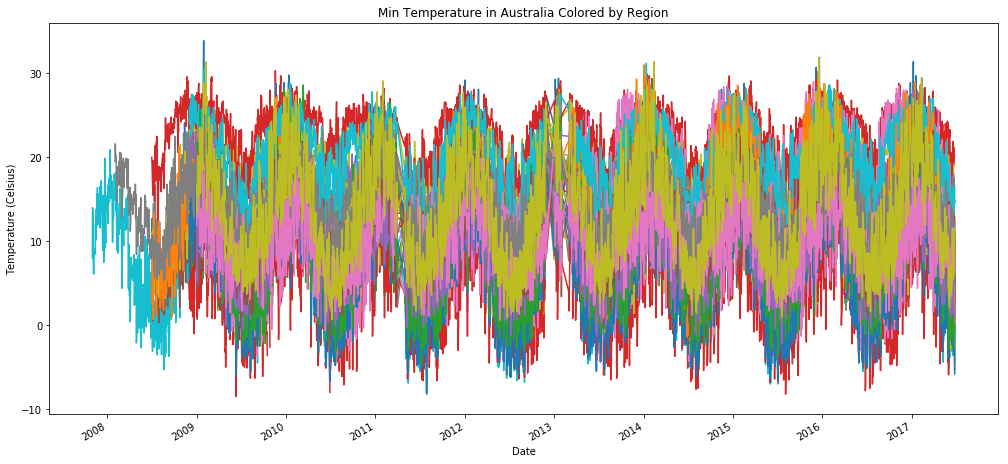

In [8]:
df.groupby('Location')['MinTemp'].plot(figsize=(17, 8))
plt.title('Min Temperature in Australia Colored by Region')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.show()

Although we don't have space to label the legend, this plot gives us an overall sense of how temperature fluctuates over time in Australia. Perhaps a good way to capture this seasonality would be to add a Month column to the data (we will do this during the modeling phase).

An interesting thing to do would be to visualize how this data varies by location in more ways than just temperature. To do this, we will perform PCA to project the data into 2-dimmensions and visualize data based on location. For fitting purposes, we will impute NaN values using acustom DataFrameImputer, which will fill string NaN's to the most frequent value while gitting numeric NaN's to the current mean. This is easy for now since we are using the whole dataset, but will require some modifications for model fitting with a train and test set.

In [9]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

    
df_nl = df.drop('Location', axis=1)
cat_cols = list(df_nl.select_dtypes(include=object, exclude=None).columns)

pipe = make_pipeline(
    DataFrameImputer(),
    StandardScaler(),
    PCA(n_components=3)   
)

X_red = pipe.fit_transform(pd.get_dummies(df_nl))

In [10]:
X_red

array([[-1.29646096,  0.41988574, -0.98019051],
       [-0.20684913,  2.09767995,  0.76573409],
       [-2.64946507,  4.21178167, -0.59044137],
       ...,
       [-0.95291056, -1.5964376 , -2.0321166 ],
       [-1.1682878 , -2.4431032 ,  0.59330806],
       [ 0.05022116, -1.18791477, -2.88747647]])

Text(0.5,1,'2D PCA Projection of Data Colored by Location')

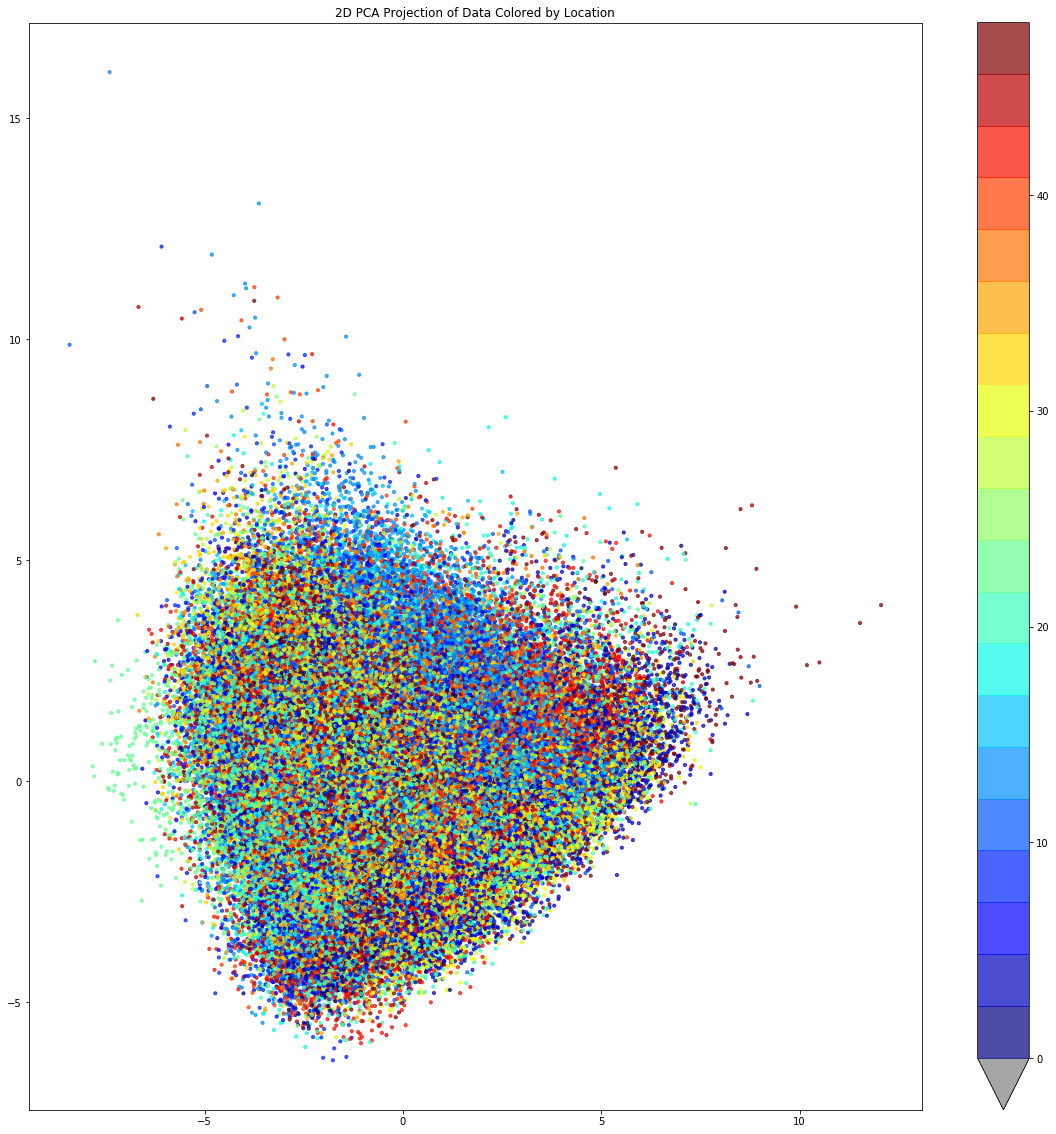

In [11]:

cmap = plt.get_cmap('jet', 20)
cmap.set_under('gray')
fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.scatter(X_red[:, 0], X_red[:, 1], c=df.Location.astype('category').cat.codes, s=10, cmap=cmap, alpha=0.7)
fig.colorbar(cax, extend='min')
plt.title('2D PCA Projection of Data Colored by Location')

Text(0.5,0.92,'3D PCA Projection of Data Colored by Location')

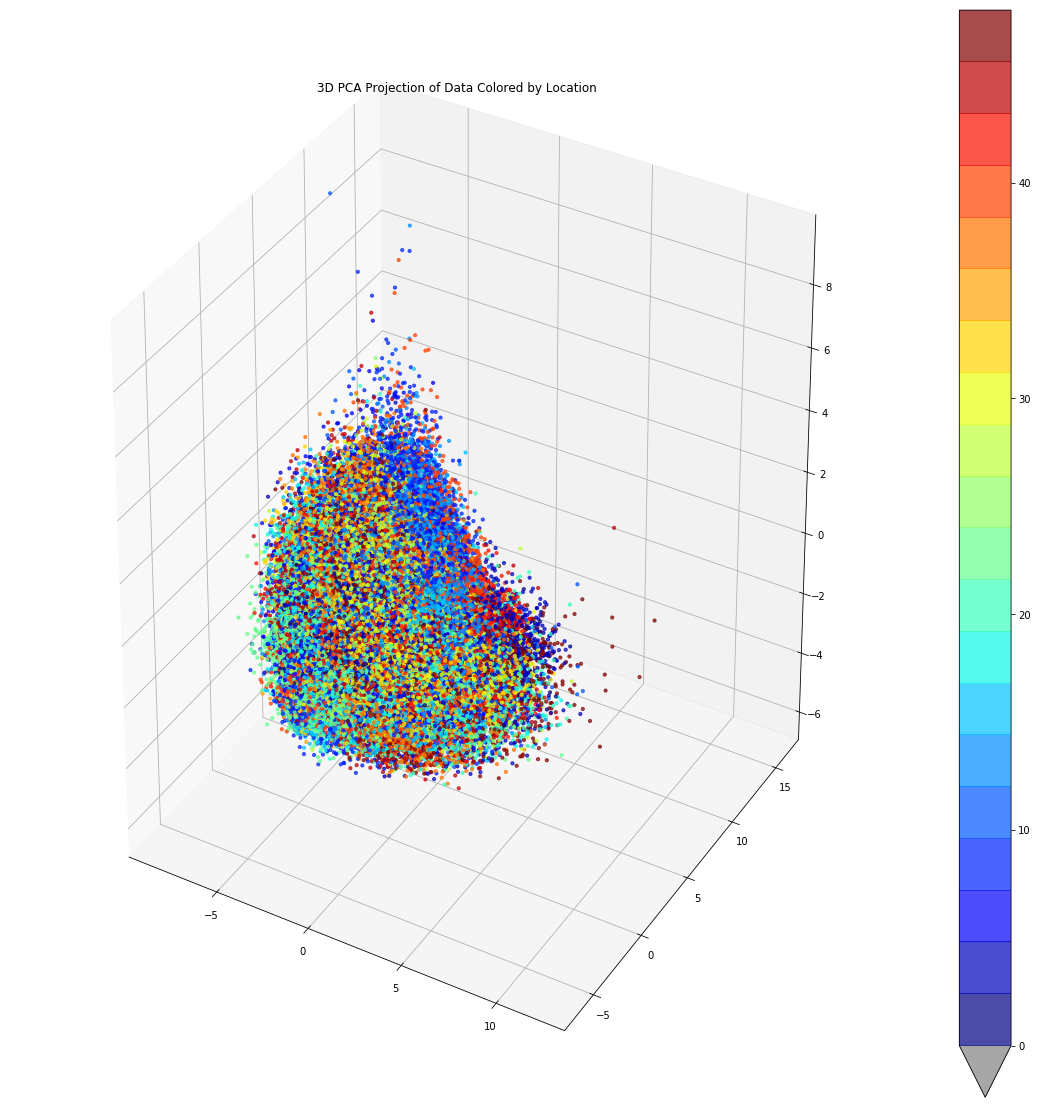

In [12]:
from mpl_toolkits.mplot3d import Axes3D

cmap = plt.get_cmap('jet', 20)
cmap.set_under('gray')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(X_red[:, 0], X_red[:, 1], X_red[:, 2], c=df.Location.astype('category').cat.codes, s=10, cmap=cmap, alpha=0.7)
fig.colorbar(cax, extend='min')
plt.title('3D PCA Projection of Data Colored by Location')

Although these two plots look like a random confetti party, they reveal some interesting information about the data. It seems that different locations have different projections as we can see from the coloring. Certain colors seem to cluster together! This tells us that location will likely be an important feature when it comes to building our model.

Recall that our goal is to predict the RainTomorrow variable. For this task, we will split our data into training and test sets, fit preprocessing steps to the training data, and finally fit a few ML algorithms to the training data.

In [14]:
X, y = df.drop('RainTomorrow', axis=1), df.RainTomorrow

# Add seasonality
X['Month'] = X.index.month_name()

cat_cols = list(X.select_dtypes(include=object).columns)
num_cols = [c for c in X.columns if c not in cat_cols]

# Add intraday delta
am_cols = sorted([c for c in num_cols if c.endswith('9am')])
pm_cols = sorted([c for c in num_cols if c.endswith('3pm')])

for am_col, pm_col in zip(am_cols, pm_cols):
    X[am_col[:-3] + '_delta'] = X[pm_col] - X[am_col]

# Add max temp - min temp
X['MaxMin_delta'] = X['MaxTemp'] - X['MinTemp']
    
# Get categoricals and numericals
cat_cols = list(X.select_dtypes(include=object).columns)
num_cols = [c for c in X.columns if c not in cat_cols]

# Avoid shuffle to preserve chronology - test set contains latest samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [15]:
X_train.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp9am,Temp3pm,RainToday,Month,Cloud_delta,Humidity_delta,Pressure_delta,Temp_delta,WindSpeed_delta,MaxMin_delta
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,...,14.4,23.6,No,November,0.0,-39.0,-4.7,9.2,14.0,16.3
2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,...,17.5,25.7,Yes,November,-2.0,-44.0,-4.0,8.2,13.0,12.9
2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,...,15.4,20.2,Yes,November,-1.0,-13.0,-2.3,4.8,0.0,9.7
2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,...,13.5,14.1,Yes,November,5.0,-6.0,1.5,0.6,-6.0,2.2
2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,...,11.1,15.4,Yes,November,0.0,-19.0,0.2,4.3,8.0,8.5


Next step is to fit preprocessing steps to our data. 

In [18]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides column selection. """
    
    def __init__(self, columns=[]):
        """ Get selected columns. """
        self.columns = columns
        
    def transform(self, X):
        """ Returns df with selected columns. """
        return X[self.columns].copy()
    
    def fit(self, X, y=None):
        """ Do nothing operation. """
        return self


# Get Pipelines

# Fit numerical pipeline
num_pipeline = make_pipeline(
    DataFrameSelector(num_cols),
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# Fit categorical pipeline
cat_pipeline = make_pipeline(
    DataFrameSelector(cat_cols),
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

# Union pipelines
full_preproc = FeatureUnion(transformer_list=[
    ("cat_pipeline", cat_pipeline),
    ("num_pipeline", num_pipeline)
])

# (Optional) Reduce dimension to contain 90% explained variance
red_preproc = make_pipeline(
    full_preproc,
    PCA(0.9)
)

In [19]:
X_train = red_preproc.fit_transform(X_train)
X_train.shape

(120864, 38)

In [20]:
X_test = red_preproc.transform(X_test)
X_test.shape

(21329, 38)

Our data is now fully preprocessed and we are ready to fit a model. We will begin with a simple Logistic regression model and see how our model does using cross validation.

In [21]:
clf = LogisticRegression()
cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8433859108797765

Even with a simple logistic regression model, we have already achieved a CV score of over 84% accuracy! This is great, but let's try to do even better. For now, we will fit this model and add it to a dictionary of models so that in the conclusion, we can simultaneously test each model on the test set.

In [22]:
clf.fit(X_train, y_train)
models = {'LogisticRegression': clf}

Next, we will fit a support vector classifier out-of-the-box and see how our model performs under cross validation. Next, we will do a grid search to optimize model performance. SVM's take a while to train, so we will need to use randomized search methods for time's sake.

In [23]:
svc = SVC()
cross_val_score(svc, X_train, y_train, cv=3, scoring='accuracy').mean()

0.8515438248285774